In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sklearn.datasets

In [2]:
# Importing Siamese.py | Neural Network is defined here
import Siamese

In [3]:
class ContrastiveLoss:
    def __init__(self, margin = 1.0) :
        self.margin = margin

    def __call__(self, output1, output2, label) :
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(label * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min = 0.0), 2))
        return loss_contrastive

In [4]:
#  Initializing the Siamese Neural Network
Net = Siamese.SiameseNeuralNetwork()
#  Declare the Contrastive Loss Function
criterion = ContrastiveLoss()
#  Declare the Optimizer
optimizer = optim.Adam(Net.parameters(), lr = 0.01, weight_decay = 0.005)

In [5]:
# Visualizing the Neural Network
from torchsummary import summary

summary(Net, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Linear-10                  [-1, 512]       4,194,816
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
             ReLU-14                  [

In [6]:
# When using these images, please give credit to AT&T Laboratories Cambridge.
# Fetching the Olivetti DataSet using SKLearn
data = sklearn.datasets.fetch_olivetti_faces()
images = data.images
labels = data.target

In [7]:
# Creating Pair Dataset as the Siamese Neural Network takes in Pairs of Images for Training

def SimaeseNetworkDataset(images, labels) :
    classes = np.unique(labels)
    # Sort the Indices of Labels According to its respective Class
    classes_index = dict()
    for label in classes :
        classes_index.setdefault(label, [index for index in range(len(labels)) if label == labels[index]])

    snn_images = []
    snn_labels = []

    for index in range(len(images)) :
        # Generation of Positive Pair - Containing the Same Person
        Positive_Index = classes_index.get(labels[index]) # List of all the Indices related to that particular class
        Positive_Image = images[np.random.choice(Positive_Index)]
        snn_images.append((images[index], Positive_Image))
        snn_labels.append(1) # Target is Put as 2 Classes such that for a Positive Pair it's 1 and 0 for Negative Pair
    
        # Generation of Negative Pair - Containing Different Persons
        Negative_Index = np.where(labels != labels[index]) # List of all the Indices that doesn't equal that particular class
        Negative_Image = images[np.random.choice(Negative_Index[0])]
        snn_images.append((images[index], Negative_Image))
        snn_labels.append(0)
    return np.array(snn_images), np.array(snn_labels)

In [8]:
snn_images, snn_labels = SimaeseNetworkDataset(images, labels)

# Conversion to Tensor
images_tensor = torch.zeros((2, 800, 1, 64, 64))
labels_tensor = torch.from_numpy(snn_labels)
for i in range(800) :
    for j in range(2) :
        images_tensor[j][i][0] = torch.from_numpy(snn_images[i][j])

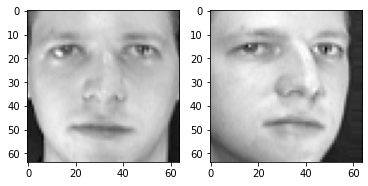

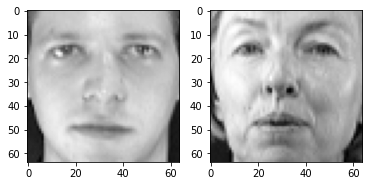

In [47]:
# Visualizing few images from images_tensor
import matplotlib.pyplot as plt

# Positive Pair
plt.subplot(1, 2, 1)
plt.imshow(images_tensor[0][0][0], cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(images_tensor[0][8][0], cmap = 'gray')
plt.show()

# Negative Pair
plt.subplot(1, 2, 1)
plt.imshow(images_tensor[0][1][0], cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(images_tensor[1][1][0], cmap = 'gray')
plt.show()

In [11]:
# Defining the Training Loop
def Train(Input, Target, EPOCH) :
    for index in range(EPOCH) :
        for itr in range(len(Target)) :
            input1 =  Input[0][itr]
            input2 =  Input[1][itr]
            label  =  Target[itr]
            optimizer.zero_grad()
            #  Pass the Pairs of Images to the Network
            output1 = Net.forward(input1)
            output2 = Net.forward(input2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
        print(f"Epoch : {index + 1} | Loss : {loss.item()}")
    torch.save(Net, 'Model.pt')
    print('Model Saved Successfully !')

In [12]:
Train(images_tensor, labels_tensor, 5)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch : 1 | Loss : 0.2810823321342468
Epoch : 2 | Loss : 0.17143714427947998
Epoch : 3 | Loss : 0.0
Epoch : 4 | Loss : 0.4737437665462494
Epoch : 5 | Loss : 0.5101397633552551
Model Saved Successfully !


In [13]:
model = torch.load('Model.pt')
# Set the loaded model to Evaluation mode
model.eval()

SiameseNeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Sequential(
    (0

In [50]:
# Generating Test Data
Q = images_tensor[0][0]
R = images_tensor[0][8]
L = torch.tensor(1)

# Testing
Qo = model(Q)
Ro = model(R)

print(criterion(Qo, Ro, L))

tensor(1.2800e-10, grad_fn=<MeanBackward0>)
